In [1]:
from typing import List, Dict
import os
import subprocess
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%run src/utils.py

In [3]:
SAMPLE = 'EY'

# Depois fazer função que lê os parametros físicos de entrada
D0 = 2.5
SMALL_DELTA = 0.1
GAMMA = 267.51289763847808

EXP_FILE = f'db/experimental/carbonates/diffusionall_{SAMPLE}_data.dat'

RWDB = f'PFGSE_NMR_18102023'
SIMS_DIR = f'db/{RWDB}/carbonates'
SIM_DIR = [d for d in os.listdir(SIMS_DIR) if parse_dirname(d)['sample'] == SAMPLE][0]
SIM_DIRPATH = os.path.join(SIMS_DIR, SIM_DIR)

SPHERES_DB = f'db/PFGSE_NMR_rtag=XsphereY'
SPHERES_DIRS = [os.path.join(SPHERES_DB, d) for d in os.listdir(SPHERES_DB) if SAMPLE in parse_dirname(d)['sample']]

In [4]:
# Sort sphere dirs based on radius

tokens = [
    sd
    .split('/')[-1]
    .split('_')[2]
    .split('sphere')[-1] 
    for sd in SPHERES_DIRS
]
tokens = np.array([int(t) for t in tokens])
tokens

def sort_list_based_on_another_list(list1, list2):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

SPHERES_DIRS = sort_list_based_on_another_list(SPHERES_DIRS, tokens)
SPHERES_DIRS

['db/PFGSE_NMR_rtag=XsphereY/PFGSE_NMR_rtag=EYsphere25_res=1.00_rho=10.50_shift=2_w=1M_ws=1_bc=mirror_axis=2_snr=0.0001',
 'db/PFGSE_NMR_rtag=XsphereY/PFGSE_NMR_rtag=EYsphere50_res=1.00_rho=10.50_shift=2_w=1M_ws=1_bc=mirror_axis=2_snr=0.0001',
 'db/PFGSE_NMR_rtag=XsphereY/PFGSE_NMR_rtag=EYsphere100_res=1.00_rho=10.50_shift=2_w=1M_ws=1_bc=mirror_axis=2_snr=0.0001',
 'db/PFGSE_NMR_rtag=XsphereY/PFGSE_NMR_rtag=EYsphere200_res=1.00_rho=10.50_shift=2_w=1M_ws=1_bc=mirror_axis=2_snr=0.0001']

In [5]:
# Load experimental results
exp_data = parse_experimental_results(EXP_FILE)

In [6]:
# Load simulation results
sim_info = parse_dirname(SIM_DIR)
pfg_dir = [d for d in os.listdir(SIM_DIRPATH) if 'NMR_pfgse' in d]
timesamples_dir = os.path.join(SIM_DIRPATH, pfg_dir[0], 'timesamples')

results_file = os.path.join(SIM_DIRPATH, pfg_dir[0], 'PFGSE_results.csv')
gradients_file = os.path.join(SIM_DIRPATH, pfg_dir[0], 'PFGSE_gradient.csv')
echoes_files = [os.path.join(timesamples_dir, f) for f in os.listdir(timesamples_dir) if 'echoes' in f]
echoes_files = order_files_by_last_token(echoes_files)

sim_results_data = parse_sim_results(results_file, ['Time','Dmsd','Dsat', 'Dsat(pts)'])
sim_gradients_data = parse_sim_results(gradients_file, ['Gz', 'Kz'])
sim_echoes_data = [parse_sim_results(ef, ['Gradient','NMR_signal(mean)']) for ef in echoes_files]

sim_data = {
    'info': sim_info,
    'results': sim_results_data,
    'gradients': sim_gradients_data,
    'echoes': sim_echoes_data
}

print(sim_data)

{'info': {'sample': 'EY', 'res': '1.00', 'rho': '10.50', 'shift': '2', 'w': '1M', 'ws': '1', 'bc': 'mirror', 'axis': '2', 'snr': '0.00001'}, 'results': {'Time': array([  10.        ,   10.43333333,   10.875     ,   11.33333333,
         11.81666667,   12.325     ,   12.85      ,   13.39166667,
         13.96666667,   14.55833333,   15.18333333,   15.825     ,
         16.5       ,   17.2       ,   17.93333333,   18.7       ,
         19.49166667,   20.325     ,   21.19166667,   22.09166667,
         23.03333333,   24.01666667,   25.03333333,   26.1       ,
         27.21666667,   28.375     ,   29.58333333,   30.84166667,
         32.15833333,   33.525     ,   34.95      ,   36.44166667,
         37.99166667,   39.60833333,   41.3       ,   43.05833333,
         44.89166667,   46.8       ,   48.79166667,   50.875     ,
         53.04166667,   55.3       ,   57.65      ,   60.10833333,
         62.66666667,   65.33333333,   68.11666667,   71.01666667,
         74.04166667,   77.2       

In [7]:
# Load isolated sphere results
spheres_data = []

for sd in SPHERES_DIRS:
    sd_info = parse_dirname(sd)
    sd_info['sample'] = sd_info['sample'].split('=')[-1]
    sd_info['radius'] = float(sd_info['sample'].split('sphere')[-1])
        
    pfg_dir = [os.path.join(sd,d) for d in os.listdir(sd) if 'NMR_pfgse' in d]
    timesamples_dir = os.path.join(pfg_dir[0], 'timesamples')
    
    sd_results_file = os.path.join(pfg_dir[0], 'PFGSE_results.csv')
    sd_gradients_file = os.path.join(pfg_dir[0], 'PFGSE_gradient.csv')
    sd_echoes_files = [os.path.join(timesamples_dir, f) for f in os.listdir(timesamples_dir) if 'echoes' in f]
    sd_echoes_files = order_files_by_last_token(sd_echoes_files)

    sd_results_data = parse_sim_results(sd_results_file, ['Time','Dmsd','Dsat', 'Dsat(pts)'])
    sd_gradients_data = parse_sim_results(sd_gradients_file, ['Gz', 'Kz'])
    sd_echoes_data = [parse_sim_results(ef, ['Gradient','NMR_signal(mean)']) for ef in sd_echoes_files]
    
    sd_data = {
        'info': sd_info,
        'results': sd_results_data,
        'gradients': sd_gradients_data,
        'echoes': sd_echoes_data
    }    
    spheres_data.append(sd_data)

print(spheres_data[0])

{'info': {'sample': 'EYsphere25', 'res': '1.00', 'rho': '10.50', 'shift': '2', 'w': '1M', 'ws': '1', 'bc': 'mirror', 'axis': '2', 'snr': '0.0001', 'radius': 25.0}, 'results': {'Time': array([  10.        ,   10.43333333,   10.875     ,   11.33333333,
         11.81666667,   12.325     ,   12.85      ,   13.39166667,
         13.96666667,   14.55833333,   15.18333333,   15.825     ,
         16.5       ,   17.2       ,   17.93333333,   18.7       ,
         19.49166667,   20.325     ,   21.19166667,   22.09166667,
         23.03333333,   24.01666667,   25.03333333,   26.1       ,
         27.21666667,   28.375     ,   29.58333333,   30.84166667,
         32.15833333,   33.525     ,   34.95      ,   36.44166667,
         37.99166667,   39.60833333,   41.3       ,   43.05833333,
         44.89166667,   46.8       ,   48.79166667,   50.875     ,
         53.04166667,   55.3       ,   57.65      ,   60.10833333,
         62.66666667,   65.33333333,   68.11666667,   71.01666667,
         74.

In [8]:
color_radius_map = {
    f'{SAMPLE}sphere25': 'blue',
    f'{SAMPLE}sphere50': 'black',
    f'{SAMPLE}sphere100': 'green',
    f'{SAMPLE}sphere200': 'gold'
}

color_radius_map

{'EYsphere25': 'blue',
 'EYsphere50': 'black',
 'EYsphere100': 'green',
 'EYsphere200': 'gold'}

<IPython.core.display.Javascript object>


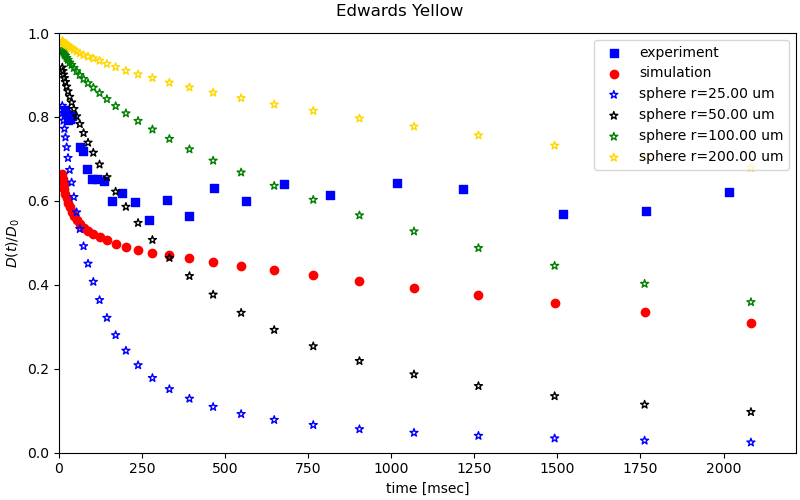

In [9]:
fig, axs = plt.subplots(1,1,figsize=(8,5),constrained_layout=True)
stride = 4

suptitle = TAG2SAMPLE_MAP[SAMPLE]
fig.suptitle(suptitle)

# plot experimental data
axs.scatter(
    exp_data['data']['time'], 
    exp_data['data']['D_D0'],
    marker='s',
    color='blue',
    label='experiment'
)

# plot simulation data
axs.scatter(
    sim_data['results']['Time'][::stride], 
    (1/D0)*sim_data['results']['Dsat'][::stride],
    marker='o',
    color='red',
    label='simulation'
)

# plot isolated spheres data
for sphere in spheres_data:
    axs.scatter(
        sphere['results']['Time'][::stride], 
        (1/D0)*sphere['results']['Dsat'][::stride],
        marker='*',
        facecolor='none',
        color=color_radius_map[f"{sphere['info']['sample']}"],
        label=f"sphere r={(float(sphere['info']['res'])*sphere['info']['radius']):.2f} um",
    )

axs.set_xlim([0,1.1*exp_data['data']['time'].iloc[-1]])
axs.set_ylim([0,1])
axs.set_xlabel('time [msec]')
axs.set_ylabel(r'$D(t)/D_0$')
axs.legend(loc='upper right')

In [10]:
plt.savefig(fname=f"figs/vugs/compilation_{SAMPLE}.svg", format="svg")
plt.savefig(fname=f"figs/vugs/compilation_{SAMPLE}.png", format="png")
plt.close('all')

# Combining signals

In [11]:
porosities = {
    'sim': 0.33,
    'sphere': 0.67,
}

In [12]:
combined_data = []

for sphere in spheres_data:
    new_sample = {}
    new_sample['sample'] = f"{sim_data['info']['sample']}_with_{sphere['info']['sample'][2:]}"
    new_sample['radius'] = sphere['info']['radius']
    new_sample['Kz'] = sim_data['gradients']['Kz']
    new_sample['echoes'] = []
    new_sample['time'] = []
    
    for ie, echo in enumerate(sphere['echoes']):
        new_signal = porosities['sim'] * sim_data['echoes'][ie]['NMR_signal(mean)']
        new_signal += porosities['sphere'] * echo['NMR_signal(mean)']
        new_sample['echoes'].append(new_signal)
        new_sample['time'].append(sim_data['results']['Time'][ie])
    combined_data.append(new_sample)

for cd in combined_data:
    print(cd['sample'], cd['echoes'][0][:3])

EY_with_sphere25 [977743.34811363 977716.43884657 977666.02724073]
EY_with_sphere50 [981885.67059831 981865.24628703 981804.21777113]
EY_with_sphere100 [983950.42110194 983923.61996627 983866.8888513 ]
EY_with_sphere200 [984958.14565882 984944.54715218 984870.27641868]


# Compute D(t)

In [16]:
for cd in combined_data:
    cd['Dsat'] = []
    for i,e in enumerate(cd['echoes']):
        Mkt = e
        print(Mkt)
        Kz = cd['Kz']
        time = cd['time'][i]     
        Dt_fit = fit_pfg_diffusion(Mkt, Kz, time, SMALL_DELTA, threshold=0.9, min_values=25)
        cd['Dsat'].append(Dt_fit)
    cd['Dsat'] = np.array(cd['Dsat'])
    print(cd['sample'], cd['Dsat'][:5])

[977743.34811363 977716.43884657 977666.02724073 977558.98958734
 977416.70165179 977237.63009178 977002.74597071 976728.49662945
 976424.97419764 976086.67885986 975675.77956029 975243.16313081
 974760.08836817 974241.76054452 973692.60250488 973100.73788585
 972443.39312073 971783.8075843  971052.0142108  970282.04103977
 969500.28826827 968659.7929122  967769.1932961  966841.29505398
 965881.54829826 964880.31681362 963845.95758406 962752.51597756
 961632.10513201 960476.80056131 959283.45029807 958033.65830089
 956762.6392633  955451.48357874 954097.61772981 952698.04793402
 951280.02923483 949808.5766368  948297.5357834  946743.48776145
 945164.85203982 943566.0686031  941906.73307138 940211.41630828
 938493.20501521 936703.59994776 934931.07125252 933096.18116953
 931223.81845715 929313.58098042 927352.81030563 925393.55121012
 923367.41936541 921318.95359464 919260.24926061 917125.4853478
 914994.78623467 912810.79141727 910607.8980165  908359.99469014
 906066.06455878 903763.73

[ 6.26003614e+05  6.25888852e+05  6.25562471e+05  6.25000327e+05
  6.24217031e+05  6.23208589e+05  6.21977989e+05  6.20544473e+05
  6.18869301e+05  6.16998721e+05  6.14909389e+05  6.12607119e+05
  6.10110373e+05  6.07405403e+05  6.04514516e+05  6.01394402e+05
  5.98108885e+05  5.94633310e+05  5.90981235e+05  5.87139504e+05
  5.83120420e+05  5.78939611e+05  5.74606553e+05  5.70094722e+05
  5.65436926e+05  5.60641025e+05  5.55688195e+05  5.50619392e+05
  5.45411913e+05  5.40090582e+05  5.34621273e+05  5.29056021e+05
  5.23394955e+05  5.17612490e+05  5.11744389e+05  5.05790453e+05
  4.99745388e+05  4.93627141e+05  4.87422856e+05  4.81152250e+05
  4.74828225e+05  4.68458340e+05  4.62004315e+05  4.55525482e+05
  4.48998754e+05  4.42449041e+05  4.35853388e+05  4.29239013e+05
  4.22596413e+05  4.15945679e+05  4.09278810e+05  4.02602956e+05
  3.95911642e+05  3.89233658e+05  3.82548865e+05  3.75870695e+05
  3.69220966e+05  3.62569652e+05  3.55935482e+05  3.49333523e+05
  3.42743619e+05  3.36206

[971670.30970571 971641.29346327 971530.1846981  971357.3984946
 971118.46707056 970816.9011093  970427.69863908 969991.02526374
 969475.27667199 968897.74125742 968255.62515315 967535.57721465
 966751.91493946 965893.7306044  964981.30118169 964009.10217112
 962957.12359232 961839.65780869 960660.31732542 959394.25684558
 958082.01101611 956725.10098629 955269.01362121 953767.25894558
 952192.607621   950542.37788114 948846.99483969 947084.93988955
 945268.89676643 943373.54488023 941424.83230876 939403.50614862
 937332.27364311 935200.92929448 932998.82357367 930747.35370251
 928435.72402224 926060.95611036 923630.98574981 921129.17385786
 918605.93337363 915994.21598905 913334.25463717 910623.20034793
 907860.91318547 905027.87401948 902146.24425898 899229.77206883
 896242.79765602 893195.23305955 890116.00541865 886993.22313517
 883799.13871648 880571.34153953 877281.46542536 873959.80087664
 870565.78101823 867143.09818265 863686.43170159 860163.13590319
 856613.89120409 853005.51

[750211.82774653 750010.60021146 749357.50406906 748296.65427661
 746787.82304754 744894.36023376 742558.67588384 739799.90307526
 736649.77307109 733079.05314976 729129.53542828 724760.61002762
 720017.48015105 714913.78973031 709434.3615377  703596.69110655
 697419.30591726 690883.25612949 684042.70245785 676869.80539669
 669413.8538251  661653.38741364 653614.70806754 645318.46487867
 636760.7197576  627979.04089698 618954.35710038 609730.19628295
 600292.94204523 590695.89101195 580923.46648854 571000.26092448
 560931.79654137 550719.55864797 540415.75800987 530032.28023829
 519542.01548143 508981.7686802  498374.52854689 487746.67896134
 477060.72544336 466357.60563843 455673.6527798  444991.46150435
 434332.67651331 423690.92928397 413133.02888873 402607.60857353
 392151.18805789 381776.12338418 371484.83761872 361308.25647724
 351219.91716427 341254.05611029 331412.94044037 321699.50862573
 312135.34210739 302690.39232504 293417.51614397 284290.39490354
 275336.81283351 266535.8

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<IPython.core.display.Javascript object>


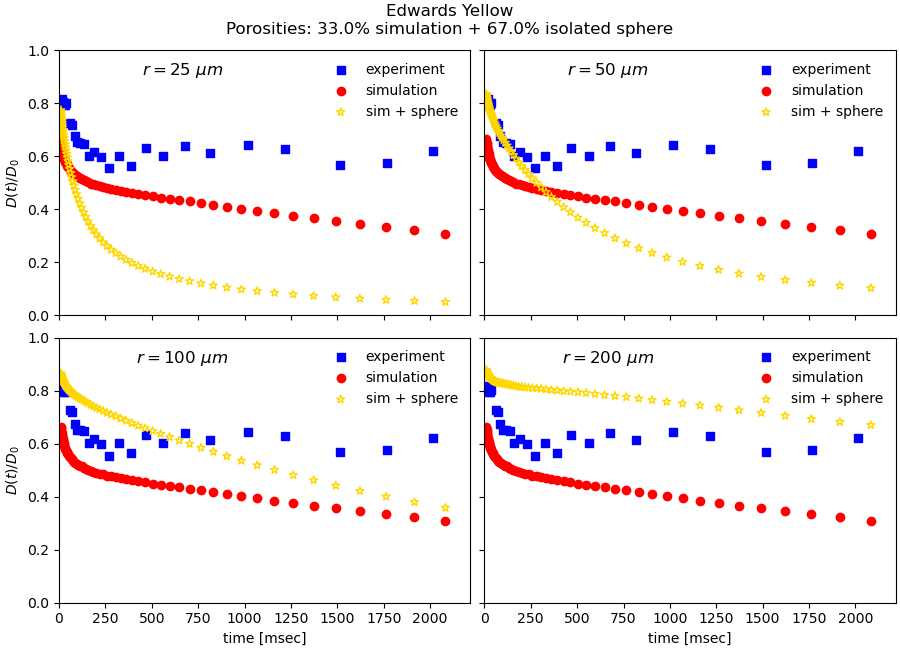

In [14]:
fig, axs = plt.subplots(2,2,figsize=(9,6.5),constrained_layout=True)
stride = 2

suptitle = TAG2SAMPLE_MAP[SAMPLE]
suptitle += f"\nPorosities: {100*porosities['sim']:.1f}% simulation + {100*porosities['sphere']:.1f}% isolated sphere"
fig.suptitle(suptitle)

for i, ax in enumerate(axs.flatten()):
    curr_rad = f"{float(spheres_data[i]['info']['res'])*spheres_data[i]['info']['radius']:.0f}"
    title = r"$r=$" + curr_rad + r" $\mu m$"
    ax.set_title(title, x=0.3, y=1, pad=-18)
    # plot experimental data
    ax.scatter(
        exp_data['data']['time'], 
        exp_data['data']['D_D0'],
        marker='s',
        color='blue',
        label='experiment'
    )

    # plot simulation data
    ax.scatter(
        sim_data['results']['Time'][::stride], 
        (1/D0)*sim_data['results']['Dsat'][::stride],
        marker='o',
        color='red',
        label='simulation'
    )

    # plot isolated spheres data
    cd = combined_data[i]
    ax.scatter(
        cd['time'][::stride], 
        (1/D0)*cd['Dsat'][::stride],
        marker='*',
        facecolor='none',
        color='gold',
        label=f"sim + sphere",
    )

for ax in axs.flatten():
    ax.set_xlim([0,1.1*exp_data['data']['time'].iloc[-1]])
    ax.set_ylim([0,1])
    ax.set_xlabel('time [msec]')
    ax.set_ylabel(r'$D(t)/D_0$')
    ax.legend(loc='upper right', frameon=False)
    ax.label_outer()

In [15]:
fname = f"figs/vugs/sim_with_spheres_{SAMPLE}_porosities_{porosities['sphere']:.1f}exp_{porosities['sim']:.1f}sim"
plt.savefig(fname=f"{fname}.svg", format='svg')
plt.savefig(fname=f"{fname}.png", format='png')
plt.close('all')